# GTEx data

Download using the following commands.
`wget https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt`

`wget https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz`

This notebook must be run in the `benchmark_env` conda environment.

In [1]:
library(edgeR)
library(limma)
library(ggplot2)
library(dplyr)
library(data.table)
library(biomaRt)
library(GSEABase)

Loading required package: limma


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int

In [2]:
# Load counts for protein coding genes.
gtex_counts_n10 <- fread("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz", nrows=10)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4505951,240.7,8250231,440.7,5603976,299.3
Vcells,7966087,60.8,15504938,118.3,12718227,97.1


In [3]:
# Load sample annotations and only keep those with counts.
gtex_annot <- fread("GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt")
gtex_annot <- gtex_annot[gtex_annot$SAMPID %in% colnames(gtex_counts_n10),]
gtex_annot$SMTS <- gsub(" ", ".", gtex_annot$SMTS, fixed=T)
gtex_annot <- gtex_annot[gtex_annot$SMTS %in% c("Brain", "Muscle", "Kidney", "Liver"),]

In [4]:
# Sample at most 10 data sets per tissue.
sel <- c()
n_samples <- 10
for (tissue in unique(gtex_annot$SMTS) ) {
    n_tissue <- sum(gtex_annot$SMTS == tissue)
    if(n_tissue > n_samples) {
        sel <- c(sel, 
                 sample(which(gtex_annot$SMTS == tissue),
                        replace = FALSE,size = min(n_tissue, n_samples)))
    }
}
gtex_annot <- gtex_annot[sel,]
gtex_annot <- gtex_annot[order(gtex_annot$SAMPID),]
dim(gtex_annot)

[1] 40 63

In [5]:
sum(table(gtex_annot$SMTS))

[1] 40

In [6]:
gtex_annot

SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,⋯,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<dbl>
GTEX-11OC5-0726-SM-5P9JK,1,B1,"2 pieces, no abnormalities",6.0,Brain,Brain - Cortex,0001870,1425,765,⋯,21463000,13117000,0.00349311,21353900,49.8726,0.06966880,0.991256,NA,0,50.5310
GTEX-11TUW-1726-SM-5BC5C,2,B1,"2 pieces, severe micro and macrovesicular steatosis",6.1,Liver,Liver,0001114,755,940,⋯,15519400,10479500,0.00371058,15636600,50.1880,0.00808154,0.995316,NA,0,49.9972
GTEX-131XH-0626-SM-5LZWH,1,B1,"2 pieces, mild macro and microvesicular steatosis",6.5,Liver,Liver,0001114,1109,668,⋯,14653800,7384620,0.00403446,14698200,50.0756,0.03002160,0.995232,NA,0,50.5883
GTEX-131YS-0011-R5b-SM-5K7YB,NA,"C1, A1",,8.8,Brain,Brain - Caudate (basal ganglia),0001873,890,NA,⋯,12379900,7774740,0.00326819,12562100,50.3652,0.03277790,0.995323,NA,0,49.6803
GTEX-1399T-0011-R11a-SM-5J2O1,NA,"B1, A1",,7.9,Brain,Brain - Cerebellar Hemisphere,0002037,745,NA,⋯,17474400,9746290,0.00535446,17597300,50.1753,0.01328950,0.989789,NA,0,50.0487
GTEX-13CF2-2726-SM-5LZWW,0,B1,"2 pieces, ~10% interstitial fat",7.6,Muscle,Muscle - Skeletal,0011907,1428,585,⋯,17090700,15875700,0.00298020,17147900,50.0835,0.01446250,0.995257,NA,0,50.0859
GTEX-13OVL-1826-SM-5KLZR,2,B1,6 pieces; no active or chronic lesions,6.0,Kidney,Kidney - Cortex,0001225,958,1155,⋯,17140300,8627510,0.00453295,17213700,50.1067,0.03545180,0.989879,NA,0,49.9772
GTEX-13OW6-1826-SM-5N9F9,1,C1,"6 pieces; mildly congested renal cortex, fibrosis",5.7,Kidney,Kidney - Cortex,0001225,629,1221,⋯,21086800,7963000,0.00411785,21260900,50.2056,0.04018090,0.987558,NA,0,50.1273
GTEX-13PVQ-0326-SM-5K7YF,1,C1,2 pieces; 5% fat,8.4,Muscle,Muscle - Skeletal,0011907,869,1155,⋯,14641200,13884100,0.00295384,14946100,50.5151,0.00912515,0.996256,NA,0,49.7484


In [7]:
# Load counts for protein coding genes.
gtex_counts <- fread("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz")
gtex_counts$Name <- gsub("\\.\\d+", "", gtex_counts$Name)
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
genes <- getBM(attributes = c('ensembl_gene_id', 'gene_biotype'), mart = ensembl)
genes <- genes[genes$gene_biotype == "protein_coding",]
gtex_counts <- gtex_counts[gtex_counts$Name %in% genes$ensembl_gene_id,]

In [8]:
sel.cols <- colnames(gtex_counts) %in% c("Name", "Description", gtex_annot$SAMPID)
gtex_counts <- gtex_counts[,sel.cols, with=FALSE]
gc()
dim(gtex_counts)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4737785,253.1,8250231,440.7,6458829,345.0
Vcells,9088877,69.4,1069358504,8158.6,1336696465,10198.2


[1] 19201    42

In [9]:
head(gtex_counts)

Name,Description,GTEX-11OC5-0726-SM-5P9JK,GTEX-11TUW-1726-SM-5BC5C,GTEX-131XH-0626-SM-5LZWH,GTEX-131YS-0011-R5b-SM-5K7YB,GTEX-1399T-0011-R11a-SM-5J2O1,GTEX-13CF2-2726-SM-5LZWW,GTEX-13OVL-1826-SM-5KLZR,GTEX-13OW6-1826-SM-5N9F9,⋯,GTEX-QDVN-1626-SM-48TZC,GTEX-QEG4-0626-SM-2S1OY,GTEX-T5JC-1526-SM-4DM68,GTEX-T5JC-1626-SM-EZ6KW,GTEX-TKQ2-0626-SM-EZ6LB,GTEX-X261-1726-SM-4PQYT,GTEX-X4XY-1626-SM-46MVN,GTEX-XMD1-0626-SM-EZ6MC,GTEX-ZDXO-0226-SM-4WKH7,GTEX-ZE7O-0326-SM-51MTH
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000186092,OR4F5,3,2,4,1,1,2,2,18,⋯,2,7,4,1,47,4,21,2,4,0
ENSG00000187634,SAMD11,115,101,102,152,48,22,1129,1062,⋯,578,24,976,2809,1253,275,137,24,1791,120
ENSG00000188976,NOC2L,3761,4368,1336,2221,4109,3021,2310,2073,⋯,3456,2483,2047,5788,3007,1293,3879,10434,2046,2898
ENSG00000187961,KLHL17,1129,447,323,349,1557,132,1173,865,⋯,876,116,842,1580,983,507,752,695,1012,248
ENSG00000187583,PLEKHN1,11,135,14,5,16,46,82,60,⋯,134,69,44,725,201,27,318,19,99,17
ENSG00000187642,PERM1,38,113,9,8,13,21110,81,137,⋯,38,18375,54,307,94,46,130,8946,77,10713


In [10]:
gtex_counts_mat <- as.matrix(gtex_counts[,3:dim(gtex_counts)[2]])
rownames(gtex_counts_mat) <- gtex_counts$Description

In [11]:
sum(gtex_annot$SAMPID == colnames(gtex_counts_mat))

[1] 40

In [12]:
dge <- DGEList(counts = gtex_counts_mat, group = gtex_annot$SMTS)
# Filter lowly expressed genes
keep <- rowSums(cpm(dge) > 0.5) > 2 #filterByExpr(dge)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [13]:
dim(dge)

[1] 16668    40

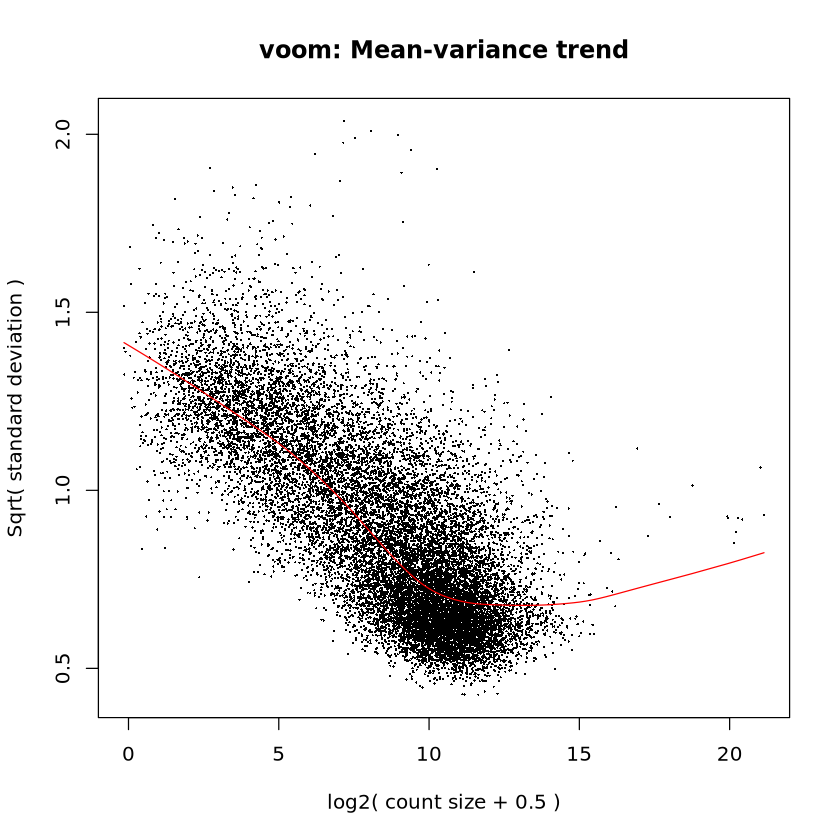

In [14]:
# Normalize the data
dge <- calcNormFactors(dge)
# Voom transformation
design <- model.matrix(~ 0 + SMTS, data = gtex_annot)
v <- voom(dge, design, plot = TRUE) 

In [15]:
# Fit linear model
fit <- lmFit(v, design)

In [16]:
# Create contrast matrix
contrast.matrix <- makeContrasts(
  Treatment_vs_Control =  SMTSBrain - SMTSLiver,
  levels = design
)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

# View top differentially expressed genes
top_genes <- topTable(fit2, adjust.method = "BH", number=Inf)

In [17]:
head(top_genes, 20)

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9546,APOA1,-14.285636,1.5678294,-34.90215,9.479332e-32,1.580015e-27,57.96080
8810,HPX,-10.857976,2.3663204,-31.97954,2.857579e-30,2.381506e-26,56.91719
1784,SDC1,-9.586996,3.9402150,-31.14196,8.000055e-30,3.333623e-26,56.16895
7805,C5,-6.062024,3.5585892,-29.26826,8.805406e-29,1.941183e-25,55.13112
12949,VTN,-9.009318,3.4260475,-29.02437,1.215618e-28,2.026191e-25,54.71170
12769,ASGR2,-9.819303,1.0239070,-30.00135,3.389272e-29,9.415398e-26,54.16311
12770,ASGR1,-6.574099,2.3131771,-27.49615,9.715941e-28,1.245733e-24,52.92539
3212,ITIH3,-11.595213,2.5838559,-29.07378,1.138504e-28,2.026191e-25,52.85291
10690,CPB2,-12.531830,-1.4422100,-30.51123,1.766666e-29,5.889358e-26,52.50483


# Human library

In [18]:
gmt_file <- "libs_human/gmt/WikiPathway_2023_Human.txt"
gene_sets <- getGmt(gmt_file)
gene_set_list <- setNames(lapply(gene_sets, function(x) geneIds(x)), names(gene_sets))

In [19]:
# CAMERA gene set enrichment analysis
camera_res <- camera(v, index = gene_set_list, design = design, contrast = contrast.matrix[,"Treatment_vs_Control"])

# View gene set enrichment results
camera_res[which(camera_res$FDR < 0.01 & camera_res$Direction == "Down"),]

,NGenes,Direction,PValue,FDR
,<dbl>,<chr>,<dbl>,<dbl>
Complement And Coagulation Cascades WP558,58,Down,4.176803e-17,3.345619e-14
Complement System WP2806,94,Down,1.119760e-13,4.484638e-11
Folate Metabolism WP176,61,Down,9.405565e-13,2.511286e-10
Complement Activation WP545,22,Down,3.426049e-12,6.860662e-10
Selenium Micronutrient Network WP15,80,Down,5.260657e-11,7.022977e-09
Disorders Of Bile Acid Synthesis And Biliary Transport WP5176,29,Down,8.306301e-11,8.969669e-09
Cholesterol Metabolism WP5304,70,Down,8.958471e-11,8.969669e-09
Vitamin B12 Metabolism WP1533,44,Down,4.997230e-10,4.002781e-08
Farnesoid X Receptor Pathway WP2879,18,Down,6.534461e-10,4.758276e-08


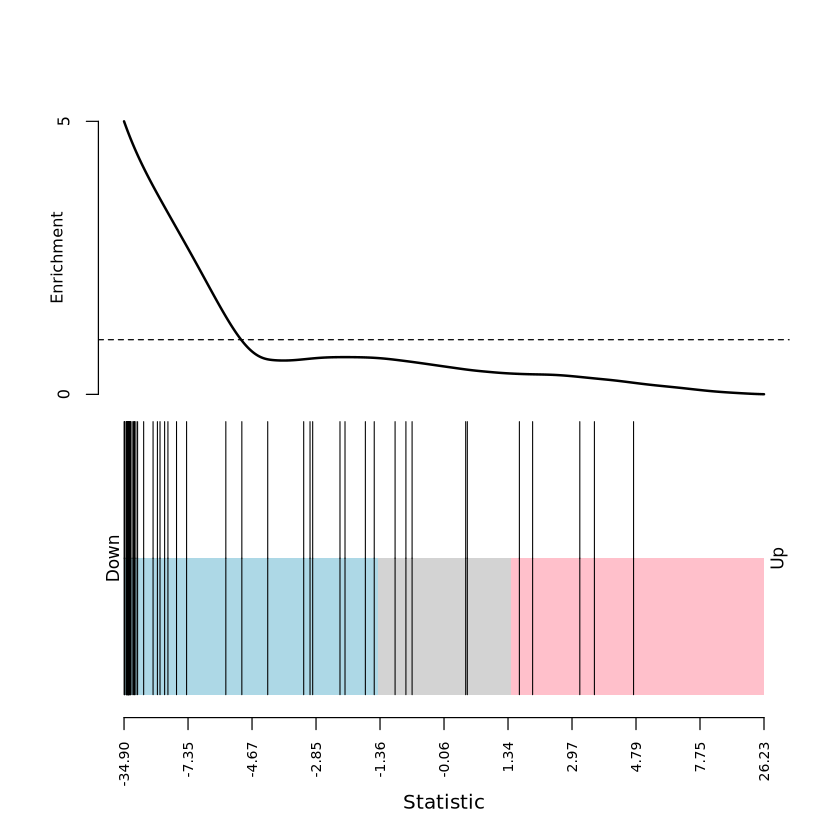

In [20]:
# Choose a gene set for the barcode plot
chosen_gene_set <- rownames(camera_res)[1]  # Choose the first gene set

# Get the gene indices for the chosen gene set
gene_indices <- gene_set_list[["Complement And Coagulation Cascades WP558"]]

# Create the barcode plot
barcodeplot(fit2$t[, 1], index = gene_indices, main = "")

Warning message:
“Removed 335 rows containing missing values or values outside the scale range
(`geom_point()`).”


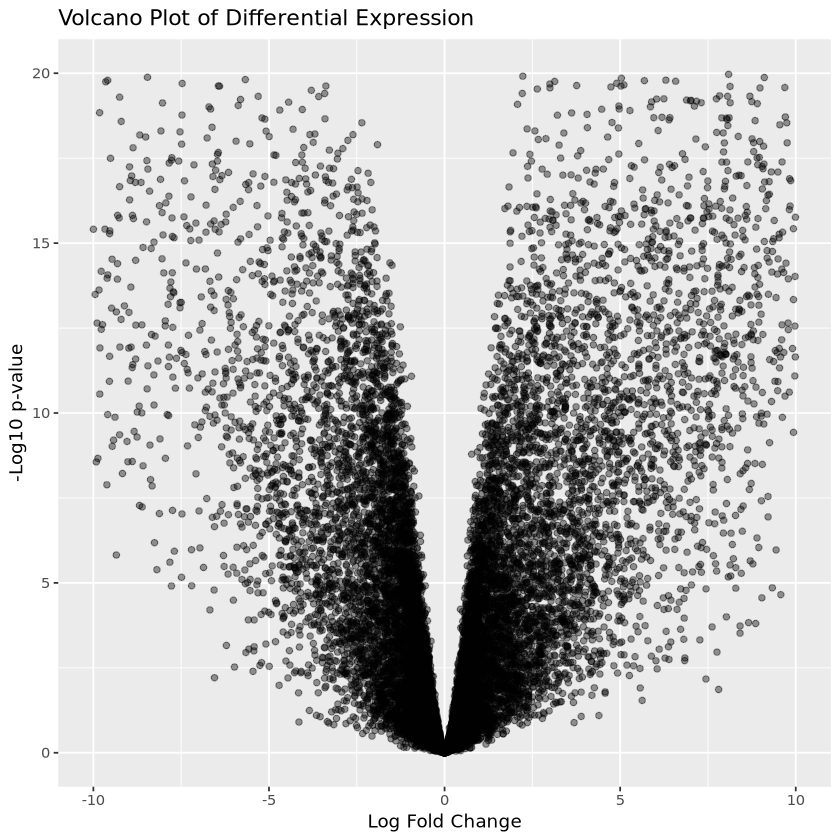

In [21]:
volcano <- ggplot(top_genes, aes(x = logFC, y = -log10(P.Value))) +
  geom_point(alpha = 0.4) +
  xlim(c(-10, 10)) +
  ylim(c(0, 20)) +
  xlab("Log Fold Change") +
  ylab("-Log10 p-value") +
  ggtitle("Volcano Plot of Differential Expression")
volcano

# LLM-tailored high Conf library

In [34]:
gmt_file2 <- "libs_human/gmt_tailored/Brain_Liver_highConf.txt"
gene_sets2 <- getGmt(gmt_file2)
gene_set_list2 <- setNames(lapply(gene_sets2, function(x) geneIds(x)), names(gene_sets2))

In [36]:
# CAMERA gene set enrichment analysis
camera_res2 <- camera(v, index = gene_set_list2, design = design, contrast = contrast.matrix[,"Treatment_vs_Control"])

# View gene set enrichment results
camera_res2[which(camera_res2$FDR < 0.01 & camera_res2$Direction == "Down"),]

,NGenes,Direction,PValue,FDR
,<dbl>,<chr>,<dbl>,<dbl>
Urea cycle,5,Down,1.122302e-05,0.0002469064
Acyl-CoA metabolic process,7,Down,4.787900e-05,0.0005266690
Mitochondrial fatty acid beta-oxidation,8,Down,1.693912e-04,0.0014906424


In [37]:
camera_res2[which(camera_res2$FDR < 0.01 & camera_res2$Direction == "Up"),]

,NGenes,Direction,PValue,FDR
,<dbl>,<chr>,<dbl>,<dbl>
Calcium Signaling in Neurons,17,Up,9.661920e-06,0.0002469064
Long-term Potentiation,8,Up,1.987336e-05,0.0002914759
Myelination,4,Up,4.106462e-04,0.0030114056
Neurotransmitter Release Cycle,4,Up,4.932750e-04,0.0031005857


# LLM-tailored with abstract

In [49]:
gmt_file3 <- "libs_human/gmt_tailored/Brain_Liver_abstract.txt"
gene_sets3 <- getGmt(gmt_file3)
gene_set_list3 <- setNames(lapply(gene_sets3, function(x) geneIds(x)), names(gene_sets3))

In [50]:
# CAMERA gene set enrichment analysis
camera_res3 <- camera(v, index = gene_set_list3, design = design, contrast = contrast.matrix[,"Treatment_vs_Control"])

# View gene set enrichment results
camera_res3[which(camera_res3$FDR < 0.01 & camera_res3$Direction == "Down"),]

,NGenes,Direction,PValue,FDR
,<dbl>,<chr>,<dbl>,<dbl>
P450 pathways,18,Down,5.212208e-09,2.397616e-07
Mono-oxygenase activity,14,Down,5.026517e-08,1.156099e-06
Acyl-CoA metabolic process,23,Down,9.850332e-08,1.510384e-06
Primary bile acid biosynthesis,8,Down,3.311802e-06,2.539048e-05
Urea cycle,11,Down,1.420368e-05,7.259657e-05
Mitochondrial fatty acid beta-oxidation,23,Down,2.177188e-05,1.001507e-04
Glucuronidation,6,Down,9.843875e-05,4.116529e-04
Kidney-bean lectin metabolic process,16,Down,1.594396e-04,5.641708e-04
Lipid droplet organization,14,Down,1.985397e-04,6.523446e-04


In [51]:
# View gene set enrichment results
camera_res3[which(camera_res3$FDR < 0.01 & camera_res3$Direction == "Up"),]

,NGenes,Direction,PValue,FDR
,<dbl>,<chr>,<dbl>,<dbl>
Calcium Signaling in Neurons,28,Up,1.353346e-07,1.556348e-06
Long-term Potentiation,36,Up,3.103506e-06,2.539048e-05
Neuronal Action Potential,26,Up,4.173226e-06,2.742406e-05
Neurovascular Coupling,28,Up,5.270584e-06,3.030586e-05
Myelination,12,Up,1.550146e-04,5.641708e-04
Neurotransmitter Release Cycle,9,Up,3.827216e-04,9.780663e-04
Maintaining Neuronal Synaptic Structure,7,Up,3.503184e-03,7.324840e-03


# human + LLM

In [62]:
combined_gene_set_list <- c(gene_set_list, gene_set_list2)

In [58]:
# CAMERA gene set enrichment analysis
camera_res4 <- camera(v, index = combined_gene_set_list, design = design, contrast = contrast.matrix[,"Treatment_vs_Control"])

In [59]:
dim(camera_res4[which(camera_res4$FDR < 0.01 & camera_res4$Direction == "Down"),])

[1] 150   4

In [60]:
dim(camera_res[which(camera_res$FDR < 0.01 & camera_res$Direction == "Down"),])

[1] 132   4

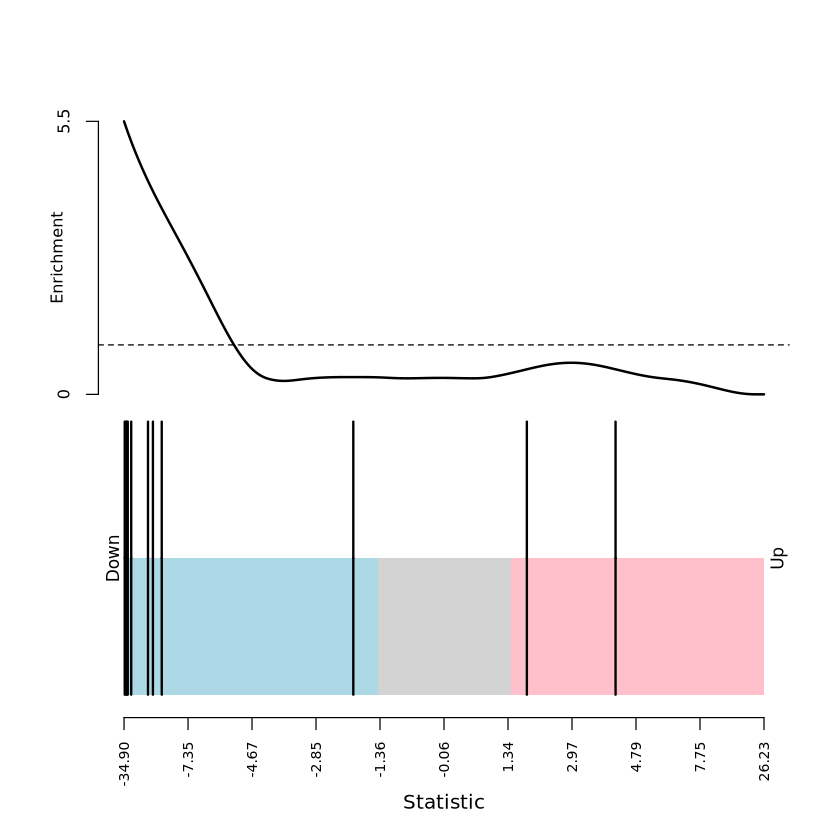

In [61]:
# Choose a gene set for the barcode plot
chosen_gene_set4 <- rownames(camera_res4)[1]  # Choose the first gene set

# Get the gene indices for the chosen gene set
gene_indices4 <- combined_gene_set_list[["Urea cycle"]]

# Create the barcode plot
barcodeplot(fit2$t[, 1], index = gene_indices4, main = "")